# Kaggle TGS Geoseismic competition

In [1]:
#!pip install -r requirements.txt

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\Users\Douglas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12229383635627508497
]


# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [2]:
!ls

datalab


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
#!kaggle datasets list

In [5]:
!kaggle competitions download -c tgs-salt-identification-challenge

/bin/sh: 1: kaggle: not found


Reference: [https://github.com/Kaggle/kaggle-api](https://github.com/Kaggle/kaggle-api)

In [6]:
!ls /content

datalab


In [0]:
#!ls /content#/competitions/tgs-salt-identification-challenge

In [0]:
#!mv ~/.kaggle/competitions/tgs-salt-identification-challenge/ /

In [0]:
#!ls /

# Data Exploration

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('content/train.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/trainData')
zip_ref.close()

In [6]:
zip_ref = zipfile.ZipFile('content/test.zip', 'r')
zip_ref.extractall('tgs-salt-identification-challenge/testData')
zip_ref.close()

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm_notebook, tnrange, tqdm

from scipy.signal import medfilt2d

Using TensorFlow backend.


In [3]:
trainFolder = 'tgs-salt-identification-challenge/trainData/'
testFolder  = 'tgs-salt-identification-challenge/testData/'

In [3]:
!ls /tgs-salt-identification-challenge/testData/

images


In [4]:
depthFile = pd.read_csv('content/depths.csv' )
depthFile.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [5]:
depthFile[depthFile['id'] == '4ac19fb269'].z.tolist()[0]

306

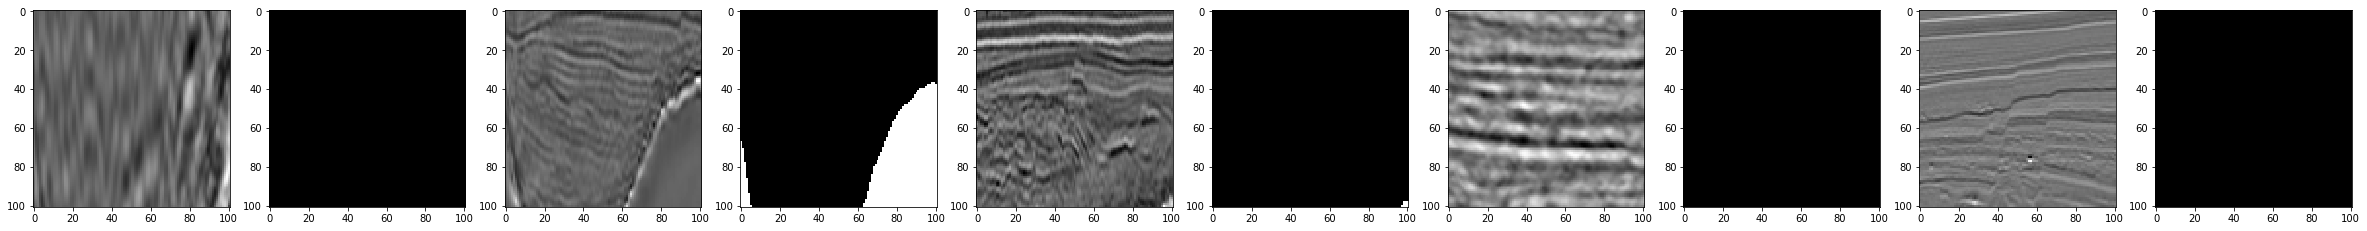

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(50,25))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(trainFolder + 'images/' + img_name + '.png')
    img_mask = load_img(trainFolder + 'masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
%load_ext autoreload
%autoreload 2

import ImageReader

In [8]:
train_ids = next(os.walk(trainFolder +"images"))[2]
test_ids = next(os.walk(testFolder +"images"))[2]

In [9]:
X_train, Y_train, depthVals = ImageReader.ReadSegmentationImages(trainFolder, depthFile)

Getting images and masks ... 


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:36<00:00, 41.51it/s]


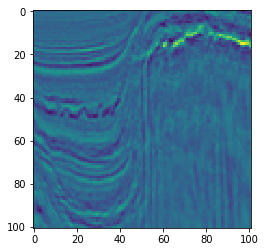

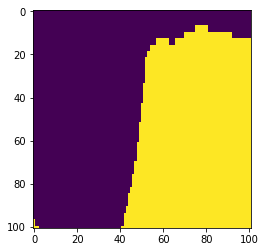

In [16]:
# Check if training data looks all right
ix = np.random.randint(0, len(train_ids))
#plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.imshow(X_train[ix,:,:,0])
plt.show()
plt.imshow(Y_train[ix,:,:,0])
plt.show()

# Keras datagen

In [98]:
valRatio = 0.02
nVal = int(len(X_train)*valRatio)
X_val = X_train[0:nVal]
Y_val = Y_train[0:nVal]
d_val = depthVals[0:nVal]

X_train0 = X_train[nVal:]
Y_train0 = Y_train[nVal:]
d_train0 = depthVals[nVal:]
X_train0.shape
print('{}, {}'.format(X_train0.shape, X_val.shape))

(3920, 101, 101, 1), (80, 101, 101, 1)


In [114]:
from keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     rotation_range=1.0, #1.0,
                     #shear_range = 0.001, #0
                     zoom_range = 0.13, #0
                     width_shift_range=0.025, # 0.03,
                     height_shift_range=0.03, #0.3,
                     horizontal_flip=True,
                     fill_mode = "reflect"
                     #vertical_flip=True #see if helps
                    )

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
depth_datagen = ImageDataGenerator()

# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(X_train0, augment=True, seed=seed)
mask_datagen.fit(Y_train0, augment=True, seed=seed)
depth_datagen.fit(d_train0, augment=False, seed=seed)


seed = 1
image_generator = image_datagen.flow(
    X_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

mask_generator = mask_datagen.flow(
    Y_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

depth_generator = depth_datagen.flow(
    d_train0,
    seed=seed,
    batch_size = 32)#32*nGPUs)

bSize = 32
def multi_input_gen(X1, X2, X3):
    genX1 = image_datagen.flow(X1, seed=seed, batch_size=bSize)
    genX2 = depth_datagen.flow(X2, seed=seed, batch_size=bSize)
    genX3 = mask_datagen.flow( X3, seed=seed, batch_size=bSize)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i, X2i], X3i

train_generator = multi_input_gen(X_train0, d_train0, Y_train0) #zip( [image_generator, depth_generator] , [mask_generator] )

493.0


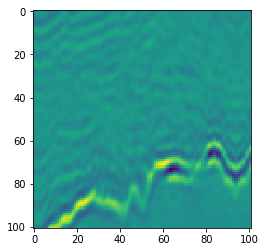

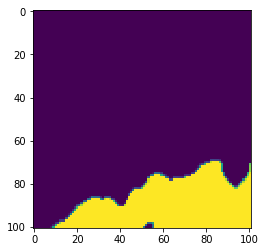

In [115]:
ans = next(train_generator)
print(ans[0][1][17,0,0,0])
plt.imshow( ans[0][0][17,:,:,0] )
plt.show()
plt.imshow( ans[1][17,:,:,0] )
plt.show()
#    
#    plt.imshow(xx[1][0][0,:,:,0])
#    plt.show()
#    break

# UNet model

In [116]:
import ModelUNet

from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, ZeroPadding2D, Cropping2D
from keras.layers.core import Lambda

In [117]:
im_height = 101
im_width = 101
im_chan = 1


inputImg = Input((im_height, im_width, im_chan))
inputDepth = Input( (1,1,1) )

s = Lambda(lambda x: x / 255) (inputImg)
dd = Lambda(lambda x: x * 0.001) (inputDepth)

#s = ReflectionPadding2D( padding = ((13, 14), (13, 14)) ) (s)
s = ZeroPadding2D( padding = ((13, 14), (13, 14)) ) (s)

unet = ModelUNet.BuildUNet(convFunction = ModelUNet.ApplyConv, net_depth=4)
s = unet([s,dd])

outputs = Cropping2D(cropping=((13, 14), (13, 14)) ) (s)

model = Model(inputs=[inputImg, inputDepth], outputs=[outputs])
model.compile(optimizer='adam', loss=ModelUNet.dice_loss, metrics=[ModelUNet.mean_iou])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 101, 101, 1)  0           input_21[0][0]                   
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 1, 1, 1)      0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 128, 128, 1)  0           lambda_16[0][0]                  
__________________________________________________________________________________________________
lambda_17 

In [118]:
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 128, 128, 8)  80          input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 128, 128, 8)  32          conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 128, 128, 8)  0           batch_normalization_81[0][0]     
__________________________________________________________________________________________________
conv2d_67 

conv2d_transpose_23 (Conv2DTran (None, 64, 64, 32)   8224        activation_68[0][0]              
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 64, 64, 32)   128         conv2d_transpose_23[0][0]        
__________________________________________________________________________________________________
concatenate_29 (Concatenate)    (None, 64, 64, 64)   0           batch_normalization_91[0][0]     
                                                                 activation_63[0][0]              
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 64, 64, 32)   18464       concatenate_29[0][0]             
__________________________________________________________________________________________________
batch_normalization_92 (BatchNo (None, 64, 64, 32)   128         conv2d_74[0][0]                  
__________

# Training

In [119]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.0032
    drop = 0.955
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [120]:
earlystopper = EarlyStopping(patience=25, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
#results = model.fit([X_train0, d_train0], Y_train0, validation_split=0.08, batch_size=16, epochs=100, 
#                    callbacks=[earlystopper, checkpointer, lrate])

results = model.fit_generator(train_generator, epochs=200, steps_per_epoch=len(X_train0) / 32, 
                              validation_data=( [X_val, d_val], Y_val),
                              callbacks=[earlystopper, checkpointer, lrate])


Epoch 1/200
Changing learning rate to 0.0032
  4/122 [..............................] - ETA: 27:13 - loss: 0.2254 - mean_iou: 0.0000e+0 - ETA: 20:08 - loss: 0.2107 - mean_iou: 0.1694    - ETA: 17:53 - loss: 0.2024 - mean_iou: 0.229 - ETA: 16:34 - loss: 0.1951 - mean_iou: 0.2625

KeyboardInterrupt: 

In [46]:
# list all data in history
print(results.history.keys())

dict_keys(['val_loss', 'val_mean_iou', 'loss', 'mean_iou'])


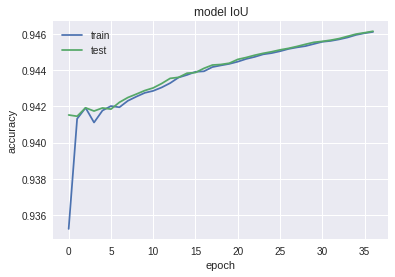

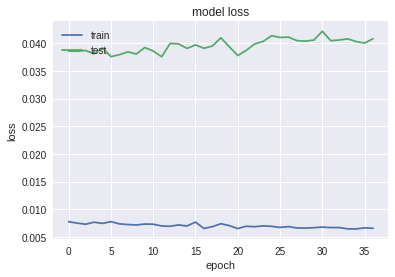

In [47]:
# summarize history for intersestion over union
plt.plot(results.history['mean_iou'])
plt.plot(results.history['val_mean_iou'])
plt.title('model IoU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def IoU(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def IoUOld(a,b):
    intersection = ((a==1) & (a==b)).sum()
    union = ((a==1) | (b==1)).sum()
    if union > 0:
        return intersection / union
    elif union == 0 and intersection == 0:
        return 1
    else:
        return 0

In [0]:
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou, 'relu6':relu6,'BilinearUpsampling':BilinearUpsampling, 'dice_loss' : dice_loss}) #, 'ReflectionPadding2D' : ReflectionPadding2D})
#model.save('model-tgs-salt-1.h5')

In [0]:
from google.colab import files
files.download('model-tgs-salt-1.h5')
#files.upload()

In [25]:
preds_train = model.predict(X_train0, verbose=1)
preds_val = model.predict(X_val, verbose=1)

48/48 [==============================] - 0s 6ms/step


In [26]:
threshList = []
IoUList = []
IoUValList = []
for kk in tqdm(range(11)):
    thresh = (1+kk)/11
    threshList.append(thresh)
    preds_train_t = (preds_train > thresh).astype(np.uint8)
    preds_val_t = (preds_val > thresh).astype(np.uint8)
    meanIoU = np.array([IoU(preds_train_t[i], Y_train0[i]) for i in range(Y_train0.shape[0])])
    IoUList.append(np.mean(meanIoU) )
    meanIoUVal = np.array([IoU(preds_val_t[i], Y_val[i]) for i in range(Y_val.shape[0])])
    
    #BUUG= =?
    IoUValList.append(np.mean(meanIoU) )

100%|██████████| 11/11 [01:21<00:00,  7.39s/it]


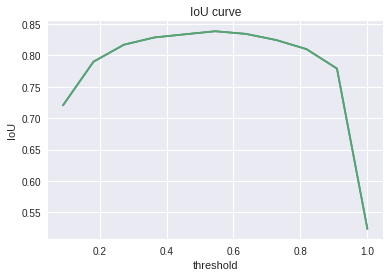

In [27]:
plt.title('IoU curve')
plt.ylabel('IoU')
plt.xlabel('threshold')

plt.plot(threshList, IoUList)
plt.plot(threshList, IoUValList)

In [28]:
thresh = threshList[np.argmax(IoUValList)]
print('Thresh: {}  ExpectedIoU: {}'.format(thresh, max(IoUValList)))

Thresh: 0.5454545454545454  ExpectedIoU: 0.8384362348178138


In [0]:
thresh = 0.5

# Predictions

In [30]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
print('Getting test images ... ')
#sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = testFolder
    img = load_img(path + 'images/' + id_)
    x = img_to_array(img)
    
    depthVal = depthFile[depthFile['id'] == id_.split('.')[0]].z.tolist()
    if len(depthVal) > 0:
        depthVal = depthVal[0]*0.255
    else:
        depthVal = 0
        print(depthVal)
        
    depthImg = depthVal+np.zeros( (im_height,im_width,1) )
    
    
    #try median filtering
    x = medfilt2d(x[:,:,0])
    x = x.reshape( (im_height,im_width,1) )
    x = np.concatenate([x, depthImg], axis=2)
    
    
    #x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x[:,:,0:2]

print('Done!')

  0%|          | 22/18000 [00:00<01:21, 219.62it/s]

Getting test images ... 


100%|██████████| 18000/18000 [01:20<00:00, 224.14it/s]

Done!


In [31]:
model_array = [
               #load_model('model-tgs-salt-Resnet.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-ReflecConv.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
               #load_model('model-tgs-salt-Incep1.h5', custom_objects={'mean_iou': mean_iou, 'ReflectionPadding2D' : ReflectionPadding2D}),
              ]

# Predict on train, val and test

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

for savedModel in model_array:
    preds_train += savedModel.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
    preds_val += savedModel.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
    preds_test += savedModel.predict(X_test, verbose=1)

preds_train /= 1+len(model_array)
preds_val /= 1+len(model_array)
preds_test /= 1+len(model_array)


# Threshold predictions
preds_train_t = (preds_train > thresh).astype(np.uint8)
preds_val_t = (preds_val > thresh).astype(np.uint8)
preds_test_t = (preds_test > thresh).astype(np.uint8)


18000/18000 [==============================] - 108s 6ms/step


In [32]:
preds_test_t.shape

(18000, 101, 101, 1)

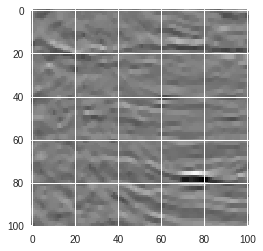

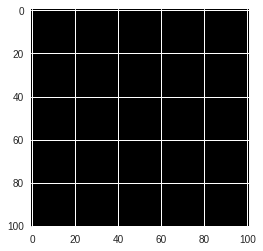

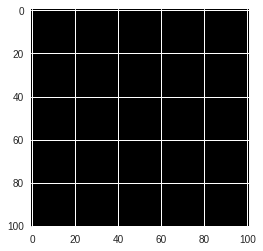

In [33]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
plt.imshow(X_train[ix,:,:,0])
plt.show()
#plt.imshow(Y_train[ix,:,:,0])
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [34]:
lowPixCount = [imgId for imgId in range(len(preds_test_t)) if preds_test_t[imgId].sum() < 10 and preds_test_t[imgId].sum() > 0]
len(lowPixCount)

7487

In [0]:
for imId in lowPixCount:
    preds_test_t[imId]=np.zeros( (101,101,1) )

# Prepare Submission

In [36]:
print(preds_test_t.shape)
preds_test = preds_test_t.reshape(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2])
print(preds_test.shape)

(18000, 101, 101, 1)
(18000, 101, 101)


In [0]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

#pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in tqdm(enumerate(test_ids))}
pred_dict = {fn[:-4]:RLenc(np.round(preds_test[i])) for i,fn in (enumerate(test_ids))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [39]:
import zipfile
try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED

modes = { zipfile.ZIP_DEFLATED: 'deflated',
          zipfile.ZIP_STORED:   'stored',
          }

print('creating archive')
zf = zipfile.ZipFile('submission.zip', mode='w')
try:
    print('adding with compression mode {}'.format(modes[compression]))
    zf.write('submission.csv', compress_type=compression)
finally:
    print('closing')
    zf.close()

print('submission.zip')

creating archive
adding with compression mode deflated
closing
submission.zip


In [40]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.zip -m "Deeplab xception + median filter on input"

Successfully submitted to TGS Salt Identification Challenge

In [0]:
from google.colab import files
files.download('submission.zip')